# Train a CNN for corner finding

In [99]:
# Imports

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

import PIL
import os
import random
import shutil
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

In [2]:
# allocate images to training, validation and test sets

# define the path to the pics
pic_path = r'J:\Drago Guggiana Nilo\Prey_capture\Corner_pics\Video\pics'
# define the paths to the divided datasets
train_path = r'J:\Drago Guggiana Nilo\Prey_capture\Corner_pics\Video\train\pics'
val_path = r'J:\Drago Guggiana Nilo\Prey_capture\Corner_pics\Video\val\pics'
test_path = r'J:\Drago Guggiana Nilo\Prey_capture\Corner_pics\Video\test'


# if os.path.isdir(train_path) is False:
#     os.makedirs(train_path)
#     os.makedirs(val_path)
#     os.makedirs(test_path)
    
#     for c in random.sample(os.listdir(pic_path), 35):
#         shutil.move(os.path.join(pic_path, c), train_path)
    
#     for c in random.sample(os.listdir(pic_path), 10):
#         shutil.move(os.path.join(pic_path, c), val_path)
    
#     for c in random.sample(os.listdir(pic_path), 5):
#         shutil.move(os.path.join(pic_path, c), test_path)

In [275]:
def parse_annotations(path_list, annotation_path, label_list=None):

    # read them as a dataframe
    annotations = pd.read_csv(annotation_path)
    # train_label = [el['filename'] for el in annotations.iterrows()]# if el['filename'] in train_list]
    labels = []

    annotated_names = annotations['filename'].to_numpy()
    # allocate a list of the paths to keep
    new_path_list = []

    # if labels are supplied, use those, otherwise extract automatically
    if label_list is not None:
        unique_labels = label_list
    else:
        # get the unique labels
        unique_labels = np.unique(annotations['region_attributes'])
        # remove the empty
        unique_labels = np.array([el for el in unique_labels if el != '{}'])
    print(unique_labels)
    for el in path_list:

        # get the current labels
        current_labels = annotations.loc[annotated_names==el,'region_attributes'].to_numpy()

        # if the file is not on the list, skip
        if len(current_labels) == 0:
            continue

        # allocate memory for the current coordinates
        current_coordinates = {label:[0, 0] for label in unique_labels}
        
        # get the entry with the coordinates
        current_entry = annotations.loc[(annotated_names==el),:]
        
        # get the labels for this pic
        for label in unique_labels:

            # if it's in the list for this file
            if label in current_labels:

                # get the actual dict of values
                current_dict = current_entry.loc[current_labels==label,'region_shape_attributes'].to_numpy()[0]
                current_dict = json.loads(current_dict.replace("'", "/"))
                
                # correct the coordinates
                current_dict['cx'] = current_dict['cx'] if current_dict['cx']<640 else current_dict['cx']-640
                current_dict['cy'] = current_dict['cy'] if current_dict['cy']<512 else current_dict['cy']-512
                                

                # load the corresponding x and y values in the labels
                current_coordinates[label] = [current_dict['cx'], current_dict['cy']]
                
        # append to the main list
        labels.append(np.vstack(list(current_coordinates.values())))
    # turn the list into an array
    
    return np.vstack(labels)

In [72]:
# parse the annotations

# define the path to the annotations
annotation_path = r'J:\Drago Guggiana Nilo\Prey_capture\Corner_pics\Video\via_project_28Aug2020_14h57m_csv.csv'

# split them based on the data splits
# get a list of the train samples
train_list = os.listdir(train_path)

# train_labels = parse_annotations(train_list, annotation_path)

print(train_labels.shape)

(80, 8)


In [405]:
# preprocess the images

# allocate memory to store them
train_images = []

# define the scaling factor
scale = 0.25

# define the x and y sizes (flipped image cause matrix coordinates)
x = int(1024*scale)
y = int(1280*scale)

# get the dimensions of the quarter images
qx = int(x/2)
qy = int(y/2)

# for all the images in the training list
for image in train_list:
    
    # load and resize the image
    current_image = \
        tf.keras.preprocessing.image.load_img(os.path.join(train_path,image), color_mode='grayscale', target_size=[x, y])
    # turn into tensor
    current_image = tf.keras.preprocessing.image.img_to_array(current_image)/255
    
    # split into 4
    train_images.append(current_image[:qx, :qy])
    train_images.append(current_image[:qx, qy:])
    train_images.append(current_image[qx:, :qy])
    train_images.append(current_image[qx:, qy:])

#     # save
#     train_images.append(current_image)
    
train_images = np.array(train_images)


In [406]:
# set up the validation data


val_list = os.listdir(val_path)

# # get the labels
# val_labels = parse_annotations(val_list)

# allocate memory to store them
val_images = []


# for all the images in the training list
for image in val_list:
    
    # load and resize the image
    current_image = \
        tf.keras.preprocessing.image.load_img(os.path.join(val_path,image), color_mode='grayscale', target_size=[x, y])
    # turn into tensor
    current_image = tf.keras.preprocessing.image.img_to_array(current_image)/255

    # split into 4
    val_images.append(current_image[:qx, :qy])
    val_images.append(current_image[:qx, qy:])
    val_images.append(current_image[qx:, :qy])
    val_images.append(current_image[qx:, qy:])
    
val_images = np.array(val_images) 

# assemble the combined data and labels
# validation_data = (val_images, val_labels)
    

In [433]:
# get the labels

labels = np.array(['{"Corner":"TL"}', '{"Corner":"TR"}', '{"Corner":"LL"}', '{"Corner":"LR"}'])

train_labels = parse_annotations(os.listdir(train_path), annotation_path, label_list=labels)#*scale
val_labels = parse_annotations(os.listdir(val_path), annotation_path, label_list=labels)#*scale

# print(train_labels)

['{"Corner":"TL"}' '{"Corner":"TR"}' '{"Corner":"LL"}' '{"Corner":"LR"}']
['{"Corner":"TL"}' '{"Corner":"TR"}' '{"Corner":"LL"}' '{"Corner":"LR"}']


In [434]:
# set up a flow for the train/validation images


# train_flow = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.15,
#     height_shift_range=0.15,
# #     vertical_flip=True,
# #     horizontal_flip=True,
# ).\
# flow(train_images, train_labels, batch_size=32)

train_flow = ImageDataGenerator().\
flow(train_images, train_labels, batch_size=32)

val_flow = ImageDataGenerator().\
flow(val_images, val_labels, batch_size=32)

In [435]:
# set up the architecture
filter_size = 2
pool_size = 2

model = Sequential([
        Conv2D(64, 4, 4, input_shape=train_images.shape[1:], activation='relu'), 
        MaxPool2D(pool_size=(pool_size)), 
        Conv2D(32, filter_size, padding='same', activation='relu'), 
        MaxPool2D(pool_size=(pool_size)), 
#         Conv2D(16, filter_size, padding='same', activation='relu'), 

#         MaxPooling2D(pool_size=(pool_size)), 
        
#         Conv2D(128, filter_size, activation='relu'), 

#         MaxPooling2D(pool_size=(pool_size)), 
        
        Flatten(), 
#         Dropout(0.4), 
#         Dense(256, activation='relu'), 
#         Dropout(0.4), 
        Dense(train_labels.shape[-1], activation='relu')
    ])

model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_absolute_error')
# model.compile(optimizer='adadelta', loss='mse')

In [436]:
print(model.summary())

Model: "sequential_93"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_237 (Conv2D)          (None, 32, 40, 64)        1088      
_________________________________________________________________
max_pooling2d_185 (MaxPoolin (None, 16, 20, 64)        0         
_________________________________________________________________
conv2d_238 (Conv2D)          (None, 16, 20, 32)        8224      
_________________________________________________________________
max_pooling2d_186 (MaxPoolin (None, 8, 10, 32)         0         
_________________________________________________________________
flatten_93 (Flatten)         (None, 2560)              0         
_________________________________________________________________
dense_93 (Dense)             (None, 2)                 5122      
Total params: 14,434
Trainable params: 14,434
Non-trainable params: 0
_________________________________________________

In [438]:
# train the model
# model.fit(x=train_images[:1], y=train_labels[:1], validation_data=(train_images[:1], train_labels[:1]), batch_size=10, epochs=300, shuffle=True, verbose=2)
# model.fit(x=train_images, y=train_labels, validation_split=0.1, batch_size=10, epochs=300, shuffle=True, verbose=2)
model.fit(train_flow, validation_data=val_flow, batch_size=32, epochs=500, shuffle=True, verbose=2)

Epoch 1/500
10/10 - 0s - loss: 8.1292 - val_loss: 10.1786
Epoch 2/500
10/10 - 0s - loss: 7.9306 - val_loss: 11.7153
Epoch 3/500
10/10 - 0s - loss: 7.9226 - val_loss: 11.3422
Epoch 4/500
10/10 - 0s - loss: 8.3497 - val_loss: 10.4375
Epoch 5/500
10/10 - 0s - loss: 8.3846 - val_loss: 11.8402
Epoch 6/500
10/10 - 0s - loss: 9.2966 - val_loss: 10.6029
Epoch 7/500
10/10 - 0s - loss: 8.9027 - val_loss: 11.2799
Epoch 8/500
10/10 - 0s - loss: 9.3659 - val_loss: 11.2294
Epoch 9/500
10/10 - 0s - loss: 8.8455 - val_loss: 11.0984
Epoch 10/500
10/10 - 0s - loss: 7.3763 - val_loss: 9.8708
Epoch 11/500
10/10 - 0s - loss: 7.8773 - val_loss: 10.6417
Epoch 12/500
10/10 - 0s - loss: 8.2205 - val_loss: 11.1931
Epoch 13/500
10/10 - 0s - loss: 7.5180 - val_loss: 10.9917
Epoch 14/500
10/10 - 0s - loss: 9.6840 - val_loss: 12.3114
Epoch 15/500
10/10 - 0s - loss: 10.9449 - val_loss: 12.3373
Epoch 16/500
10/10 - 0s - loss: 10.4414 - val_loss: 11.4794
Epoch 17/500
10/10 - 0s - loss: 8.4759 - val_loss: 12.3251
Epoch

Epoch 140/500
10/10 - 0s - loss: 10.4514 - val_loss: 11.5031
Epoch 141/500
10/10 - 0s - loss: 9.0331 - val_loss: 10.6010
Epoch 142/500
10/10 - 0s - loss: 8.2625 - val_loss: 10.9672
Epoch 143/500
10/10 - 0s - loss: 7.4368 - val_loss: 11.6974
Epoch 144/500
10/10 - 0s - loss: 7.6032 - val_loss: 11.8737
Epoch 145/500
10/10 - 0s - loss: 6.3366 - val_loss: 9.6610
Epoch 146/500
10/10 - 0s - loss: 5.9286 - val_loss: 10.2817
Epoch 147/500
10/10 - 0s - loss: 7.0973 - val_loss: 10.1585
Epoch 148/500
10/10 - 0s - loss: 6.8895 - val_loss: 10.4111
Epoch 149/500
10/10 - 0s - loss: 9.5033 - val_loss: 14.0222
Epoch 150/500
10/10 - 0s - loss: 9.5940 - val_loss: 11.7009
Epoch 151/500
10/10 - 0s - loss: 8.6531 - val_loss: 9.9226
Epoch 152/500
10/10 - 0s - loss: 7.9091 - val_loss: 10.5895
Epoch 153/500
10/10 - 0s - loss: 9.1953 - val_loss: 11.3697
Epoch 154/500
10/10 - 0s - loss: 8.1643 - val_loss: 9.9411
Epoch 155/500
10/10 - 0s - loss: 6.9351 - val_loss: 10.5718
Epoch 156/500
10/10 - 0s - loss: 7.0549 - 

Epoch 278/500
10/10 - 0s - loss: 5.3375 - val_loss: 9.1201
Epoch 279/500
10/10 - 0s - loss: 4.9563 - val_loss: 10.6251
Epoch 280/500
10/10 - 0s - loss: 6.8022 - val_loss: 8.0831
Epoch 281/500
10/10 - 0s - loss: 6.9662 - val_loss: 11.2286
Epoch 282/500
10/10 - 0s - loss: 7.4101 - val_loss: 12.6131
Epoch 283/500
10/10 - 0s - loss: 7.6416 - val_loss: 9.6033
Epoch 284/500
10/10 - 0s - loss: 5.8245 - val_loss: 9.2380
Epoch 285/500
10/10 - 0s - loss: 6.8273 - val_loss: 10.9760
Epoch 286/500
10/10 - 0s - loss: 7.1300 - val_loss: 7.8912
Epoch 287/500
10/10 - 0s - loss: 6.8427 - val_loss: 11.8061
Epoch 288/500
10/10 - 0s - loss: 7.4377 - val_loss: 9.4325
Epoch 289/500
10/10 - 0s - loss: 5.1308 - val_loss: 9.4758
Epoch 290/500
10/10 - 0s - loss: 5.9155 - val_loss: 8.5846
Epoch 291/500
10/10 - 0s - loss: 5.3687 - val_loss: 8.2984
Epoch 292/500
10/10 - 0s - loss: 5.1853 - val_loss: 8.9333
Epoch 293/500
10/10 - 0s - loss: 7.1137 - val_loss: 12.0595
Epoch 294/500
10/10 - 0s - loss: 6.6556 - val_loss

Epoch 417/500
10/10 - 0s - loss: 7.1763 - val_loss: 8.2295
Epoch 418/500
10/10 - 0s - loss: 4.6206 - val_loss: 8.2282
Epoch 419/500
10/10 - 0s - loss: 4.7410 - val_loss: 10.3288
Epoch 420/500
10/10 - 0s - loss: 6.3219 - val_loss: 8.9810
Epoch 421/500
10/10 - 0s - loss: 4.9958 - val_loss: 8.2652
Epoch 422/500
10/10 - 0s - loss: 5.4106 - val_loss: 8.2387
Epoch 423/500
10/10 - 0s - loss: 4.8346 - val_loss: 9.8721
Epoch 424/500
10/10 - 0s - loss: 5.0584 - val_loss: 9.2453
Epoch 425/500
10/10 - 0s - loss: 5.3958 - val_loss: 8.7626
Epoch 426/500
10/10 - 0s - loss: 5.6203 - val_loss: 8.4359
Epoch 427/500
10/10 - 0s - loss: 4.9949 - val_loss: 8.5855
Epoch 428/500
10/10 - 0s - loss: 4.6992 - val_loss: 9.2454
Epoch 429/500
10/10 - 0s - loss: 5.1445 - val_loss: 10.4888
Epoch 430/500
10/10 - 0s - loss: 6.4677 - val_loss: 10.6358
Epoch 431/500
10/10 - 0s - loss: 7.6484 - val_loss: 13.6209
Epoch 432/500
10/10 - 0s - loss: 7.7710 - val_loss: 11.6606
Epoch 433/500
10/10 - 0s - loss: 6.0350 - val_loss:

[30, 53, 64, 20, 34, 14, 10, 50, 12, 69]
[[ 80.  237. ]
 [238.   35.5]
 [ 46.   28.5]
 [ 21.5  40. ]
 [ 86.5 237. ]
 [ 82.  236. ]
 [ 86.  237. ]
 [ 84.5 234. ]
 [ 23.   29. ]
 [236.   36.5]]


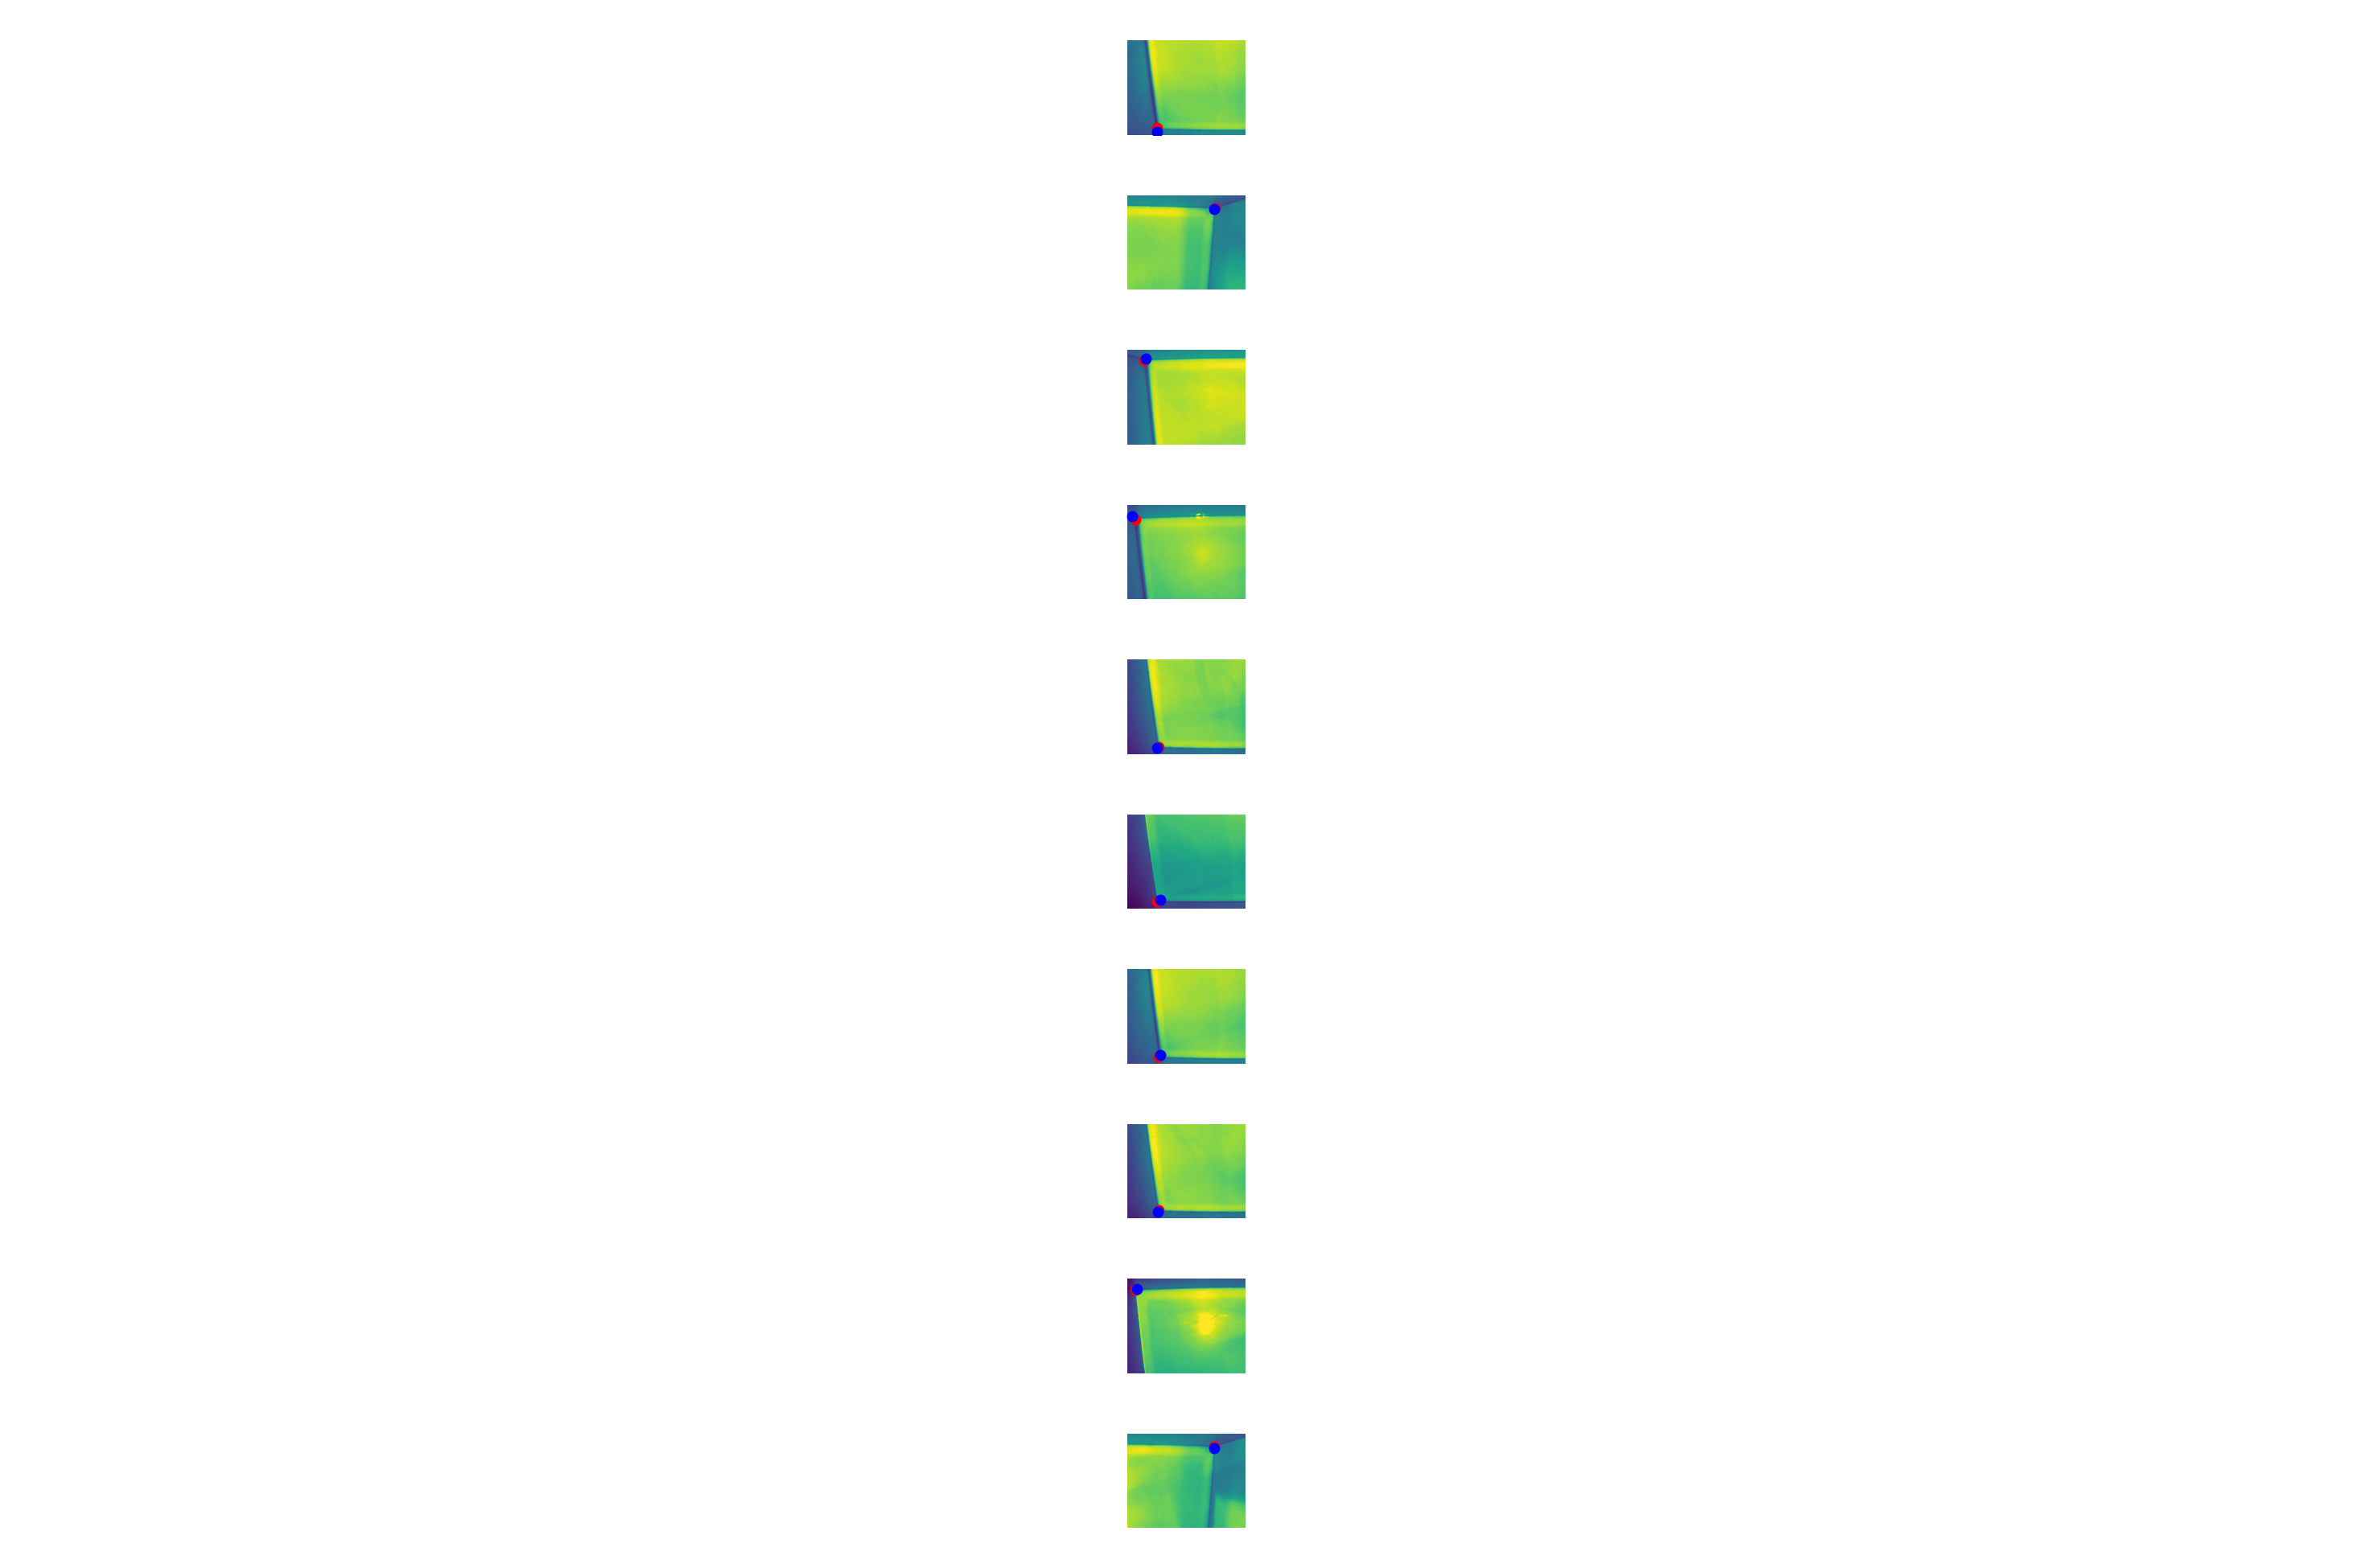

In [404]:
# visualize examples

# define the number of images to plot
number_images = 10

# select the set of images to check
target_images = val_images
target_labels = val_labels

# get random indexes for the images
image_idx = random.sample(list(np.arange(target_images.shape[0])), number_images)
# image_idx = [3]

print(image_idx)

# get the predictions
# fitted_labels = np.reshape(model.predict(train_images[image_idx]),[number_images, 4, -1])
fitted_labels = model.predict(target_images[image_idx])
# print(fitted_labels)


# get the real labels
# real_labels = np.reshape(train_labels[image_idx], [number_images, 4, -1])
real_labels = target_labels[image_idx]
print(real_labels)

# create the image
fig, ax = plt.subplots(number_images, 1, dpi= 500, squeeze=False)

ax = ax.flatten()
# for all the images
for idx, image in enumerate(image_idx):
# # get the labels


    ax[idx].imshow(np.squeeze(target_images[image]))

#     ax[idx].scatter(real_labels[idx, :, 0], real_labels[idx, :, 1],1,'red')
# #     print(real_labels[idx, :, :]*4)
#     ax[idx].scatter(fitted_labels[idx, :, 0], fitted_labels[idx, :, 1],1,'blue')

    ax[idx].scatter(real_labels[idx, 0], real_labels[idx, 1],1,'red')
#     print(real_labels[idx, :, :]*4)
    ax[idx].scatter(fitted_labels[idx, 0], fitted_labels[idx, 1],1,'blue')
    ax[idx].axis('equal')
    ax[idx].axis('off')
plt.tight_layout()
# plt.show()


In [ ]:
# save the model